In [17]:
import gzip

chr3_ids = set()
with gzip.open("gencode.v48.annotation.gtf.gz", "rt") as f:
    for line in f:
        if line.startswith("#"):
            continue
        cols = line.strip().split('\t')
        if len(cols) < 9:
            continue
        chrom, feature_type, attributes = cols[0], cols[2], cols[8]
        if chrom == "chr3" and feature_type == "gene":
            attrs = {kv.split(' ')[0]: kv.split(' ')[1].strip('"') 
                     for kv in attributes.strip(';').split('; ') if ' ' in kv}
            gene_id = attrs.get('gene_id')
            if gene_id:
                chr3_ids.add(gene_id)

print(f"Нашли {len(chr3_ids)} генов на хромосоме 3.")


Нашли 4158 генов на хромосоме 3.


TypeError: 'set' object is not subscriptable

In [ ]:
import pandas as pd
from tqdm import tqdm

# Размер чанка подбирается по памяти — можно увеличить при необходимости
chunksize = 5000
results = []

with pd.read_csv("gene_tpm_non_lcm.gct", sep='\t', skiprows=2, chunksize=chunksize, low_memory=False) as reader:
    for chunk in tqdm(reader, desc="Фильтрация по хромосоме 3"):
        chunk['gene_id_clean'] = chunk['Name'].str.split('.').str[0]
        filtered_chunk = chunk[chunk['gene_id_clean'].isin(chr3_ids)]
        results.append(filtered_chunk)

# Объединяем все отфильтрованные чанки в один датафрейм
df_chr3 = pd.concat(results, ignore_index=True)

print(f"Финальный размер данных по хромосоме 3: {df_chr3.shape}")


In [20]:
df_chr3.to_csv("gene_tpm_chr3_filtered.csv", index=False)


In [1]:
import pandas as pd

# Путь к исходному файлу
input_file = 'Median_expressions.gct'

# Путь к выходному файлу
output_file = 'MedEx_filtered.gct'

# Список интересующих тканей
tissues_of_interest = [
    'Muscle - Skeletal',
    'Whole Blood',
    'Brain - Frontal Cortex (BA9)'
]

# Чтение файла, пропуская первые две строки
df = pd.read_csv(input_file, sep='\t', skiprows=2)

# Проверка наличия интересующих тканей в столбцах
available_tissues = [tissue for tissue in tissues_of_interest if tissue in df.columns]

# Выбор столбцов: 'Name', 'Description' и интересующие ткани
columns_to_keep = ['Name', 'Description'] + available_tissues
filtered_df = df[columns_to_keep]

# Сохранение отфильтрованных данных в новый файл
# Добавим первые две строки, как в оригинальном GCT-файле
with open(output_file, 'w') as f:
    # Первая строка: версия формата
    f.write('#1.2\n')
    # Вторая строка: количество строк и столбцов
    f.write(f'{filtered_df.shape[0]}\t{filtered_df.shape[1] - 2}\n')
    # Сохранение данных
    filtered_df.to_csv(f, sep='\t', index=False)


C:\Users\stepo\AppData\Local\Temp\ipykernel_23168\2774589113.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [10]:
print(type(gene_coords))

<class 'dict'>


In [19]:
import csv

gene_coords = {}

with open("gencode.v48.annotation.gtf", "r") as gtf:
    for line in gtf:
        if line.startswith("#"):
            continue
        fields = line.strip().split("\t")
        if len(fields) < 9 or fields[2] != "gene":
            continue

        attr_field = fields[8]
        chrom = fields[0]
        start = fields[3]
        end = fields[4]

        # Извлекаем gene_id и gene_name из строки атрибутов
        attr_parts = attr_field.split(";")
        gene_id = None
        gene_name = None
        for part in attr_parts:
            part = part.strip()
            if part.startswith("gene_id"):
                gene_id = part.split('"')[1]
            if part.startswith("gene_name"):
                gene_name = part.split('"')[1]

        if gene_id:
            gene_coords[gene_id] = (chrom, start, end, gene_name)

# Проверка: выведем первые 5 записей
for i, (gid, info) in enumerate(gene_coords.items()):
    chrom, start, end, gene_name = info
    print(f"gene_id: {gid}, gene_name: {gene_name}, chrom: {chrom}, start: {start}, end: {end}")
    if i > 4:
        break


gene_id: ENSG00000290825.2, gene_name: DDX11L16, chrom: chr1, start: 11121, end: 24894
gene_id: ENSG00000223972.6, gene_name: DDX11L1, chrom: chr1, start: 12010, end: 13670
gene_id: ENSG00000310526.1, gene_name: WASH7P, chrom: chr1, start: 14356, end: 30744
gene_id: ENSG00000227232.6, gene_name: WASH7P, chrom: chr1, start: 14696, end: 24886
gene_id: ENSG00000278267.1, gene_name: MIR6859-1, chrom: chr1, start: 17369, end: 17436
gene_id: ENSG00000243485.6, gene_name: MIR1302-2HG, chrom: chr1, start: 28589, end: 31109


In [ ]:
import csv

# Пути к файлам
gct_file = "MedEx_filtered.gct"
output_csv = "MedEx_with_coords.csv"

# Читаем GCT вручную
with open(gct_file, "r") as f:
    lines = f.readlines()

# Пропускаем первые две строки
data_lines = lines[2:]

# Заголовок
header = data_lines[0].strip().split("\t")[2:]  # Пропускаем Name и Description

# Данные
parsed_rows = []
for line in data_lines[1:]:
    parts = line.strip().split("\t")
    
    # Проверяем, что строка имеет правильное количество элементов
    if len(parts) >= 2:
        full_id = parts[0]
        base_id = full_id.split(".")[0]  # отрезаем версию
        gene_name = parts[1]
        expression_values = parts[2:]
        parsed_rows.append((full_id, base_id, gene_name, expression_values))
    else:
        print(f"❌ Ошибка в строке (неправильное количество колонок): {line.strip()}")

# Собираем финальные строки
final_header = ["gene_id", "gene_name", "chromosome", "start", "end"] + header
final_rows = []

for full_id, base_id, gene_name, expr_values in parsed_rows:
    chrom, start, end = gene_coords.get(base_id, ("NA", "NA", "NA"))
    final_rows.append([full_id, gene_name, chrom, start, end] + expr_values)

# Сохраняем в CSV
with open(output_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(final_header)
    writer.writerows(final_rows)

print(f"✅ Сохранено: {output_csv}")


In [26]:
import csv

# 1. Упростим gene_name в gene_coords
simplified_coords = {}
for gene_id, (chrom, start, end, gene_name) in gene_coords.items():
    base_name = gene_name if gene_name else gene_name
    simplified_coords[base_name] = (chrom, start, end)


found = 0
not_found = 0
output_rows = []

with open("MedEx_with_coords.csv", "r", newline="") as infile:
    reader = csv.DictReader(infile, delimiter=";")
    
    # Стрипаем заголовки колонок
    reader.fieldnames = [name.strip() for name in reader.fieldnames]
    print("Имена колонок:", reader.fieldnames)  # DEBUG
    
    for row in reader:
        gene_name_raw = row.get("gene_name", "").strip()
        
        base_name = gene_name_raw
        if base_name in simplified_coords:
            chrom, start, end = simplified_coords[base_name]
            row["chromosome"] = chrom
            row["start"] = start
            row["end"] = end
            found += 1
        else:
            not_found += 1

        output_rows.append(row)

# 3. Сохраняем результат
with open("MedEx_with_coords_filled.csv", "w", newline="") as outfile:
    writer = csv.DictWriter(outfile, fieldnames=reader.fieldnames, delimiter=";")
    writer.writeheader()
    writer.writerows(output_rows)

# 4. Отчёт
print(f"✅ Найдено координат: {found}")
print(f"❌ Не найдено: {not_found}")
print(f"📁 Записано в файл: MedEx_with_coords_filled.csv")


Имена колонок: ['gene_id', 'gene_name', 'chromosome', 'start', 'end', 'Muscle - Skeletal', 'Whole Blood', 'Frontal Cortex']
✅ Найдено координат: 35858
❌ Не найдено: 20342
📁 Записано в файл: MedEx_with_coords_filled.csv


In [27]:
print("RP11-34P13.14" in [val[3] for val in gene_coords.values()])


False


In [29]:
import csv

input_file = "MedEx_with_coords_filled.csv"
output_file = "MedEx_cleaned.csv"

filtered_rows = []

with open(input_file, "r", newline='') as infile:
    reader = csv.DictReader(infile, delimiter=';')  # меняем на ',' если надо
    fieldnames = reader.fieldnames

    for row in reader:
        if row["chromosome"] != "NA" and row["start"] != "NA" and row["end"] != "NA":
            filtered_rows.append(row)

with open(output_file, "w", newline='') as outfile:
    writer = csv.DictWriter(outfile, fieldnames=fieldnames, delimiter=';')
    writer.writeheader()
    writer.writerows(filtered_rows)

print(f"Сохранено {len(filtered_rows)} строк без NA координат.")


Сохранено 35858 строк без NA координат.


In [30]:
import csv
import os
from collections import defaultdict

# Название очищенного файла
input_file = "MedEx_cleaned.csv"

# Ткани и соответствующие названия столбцов
tissues = {
    "Muscle_Skeletal": "Muscle - Skeletal",
    "Whole_Blood": "Whole Blood",
    "Frontal_Cortex": "Frontal Cortex"
}

# Создаем папки под каждый тип ткани
for tissue in tissues:
    os.makedirs(tissue, exist_ok=True)

# Словарь: {tissue: {chrom: [строки для bed]}}
bed_data = {tissue: defaultdict(list) for tissue in tissues}

# Читаем таблицу
with open(input_file, "r", newline="") as infile:
    reader = csv.DictReader(infile, delimiter=';')  # меняй на ',' если файл с запятыми
    for row in reader:
        chrom = row["chromosome"]
        start = row["start"]
        end = row["end"]

        if not chrom.startswith("chr"):
            chrom = "chr" + chrom

        for tissue, colname in tissues.items():
            expr = row[colname]
            # Без выражения - пропускаем
            if expr.strip() in {"", "NA"}:
                continue
            try:
                float(expr)  # проверка на число
            except ValueError:
                continue
            bed_data[tissue][chrom].append(f"{chrom}\t{start}\t{end}\t{expr}\t+\n")

# Записываем .bed файлы
for tissue, chrom_dict in bed_data.items():
    for chrom, lines in chrom_dict.items():
        bed_filename = os.path.join(tissue, f"{chrom}.bed")
        with open(bed_filename, "w") as bedfile:
            bedfile.writelines(lines)

print("Готово: все .bed-файлы созданы по папкам.")


Готово: все .bed-файлы созданы по папкам.


In [31]:
import os
import csv

input_file = "TADmap_geneset_hs.csv"
output_dir = "TAD_domains"
os.makedirs(output_dir, exist_ok=True)

# Словарь: хромосома → список доменов
chrom_to_domains = {}

total_length = 0
domain_count = 0

with open(input_file, "r", newline='', encoding="utf-8") as f:
    reader = csv.reader(f)
    next(reader)  # Пропускаем заголовок

    for row in reader:
        if not row or not row[0]:
            continue
        tad_info, *_ = row
        parts = tad_info.split(",")[0].split("|")
        if len(parts) < 4:
            continue
        tad_id, chrom, start, end = parts
        start, end = int(start), int(end)

        chrom = chrom if chrom.startswith("chr") else f"chr{chrom}"
        chrom_to_domains.setdefault(chrom, []).append((start, end))

        total_length += end - start
        domain_count += 1

# Запись .bed файлов
for chrom, domains in chrom_to_domains.items():
    with open(os.path.join(output_dir, f"{chrom}.bed"), "w") as f:
        for start, end in sorted(domains):
            f.write(f"{chrom}\t{start}\t{end}\n")

# Вывод средней длины домена
if domain_count > 0:
    avg_length = total_length / domain_count
    print(f"Средняя длина TAD-домена: {avg_length:.2f} bp (всего доменов: {domain_count})")
else:
    print("Доменов не найдено.")


Средняя длина TAD-домена: 874061.26 bp (всего доменов: 3036)


In [130]:
import matplotlib.pyplot as plt
import csv
import ipywidgets as widgets

# Чтение данных из файла
input_file = "TADmap_geneset_hs.csv"
chromosome = "chr15"

# Словарь для хранения доменов
domains = []

# Чтение таблицы и извлечение данных по хромосоме chr15
with open(input_file, "r", newline='', encoding="utf-8") as f:
    reader = csv.reader(f)
    next(reader)  # Пропускаем заголовок

    for row in reader:
        if not row or not row[0]:
            continue
        tad_info, *_ = row
        parts = tad_info.split(",")[0].split("|")
        if len(parts) < 4:
            continue
        tad_id, chrom, start, end = parts
        start, end = int(start), int(end)

        if chrom == chromosome:
            genes = row[1].split("|")  # Список генов из этого домена
            num_genes = len(genes)
            domains.append((start, end, num_genes))

# Длина хромосомы для человека (хромосома 15)
chrom_length = 102000000

# Находим максимальное количество генов среди доменов
max_genes = max([num_genes for _, _, num_genes in domains])

# Рассчитываем среднее количество генов
mean_genes = sum([num_genes for _, _, num_genes in domains]) / len(domains)
print(mean_genes)
# Фильтруем домены, оставляя только те, где количество генов >= 30% от среднего
filtered_domains = [domain for domain in domains if domain[2] >= 8]

lengths = [end - start for start, end, _ in filtered_domains]
print(f"Mean Len: {max(lengths) / len(lengths)}")

# Функция для построения графика с зумом
def plot_graph(x_min, x_max):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Строим столбики для доменов в пределах выбранного диапазона
    for start, end, num_genes in filtered_domains:
        if start >= x_min and end <= x_max:
            # Нормируем высоту столбика
            height = num_genes / max_genes
            ax.barh(0, end - start, left=start, height=height, align='center')
            ax.text((start + end) / 2, height / 2, str(num_genes), ha='center', va='center', color='grey', fontsize=8)

    # Добавляем оси и подписи
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Длина хромосомы (bp)')
    ax.set_title(f'Гены на хромосоме {chromosome} и их распределение по доменам')
    plt.grid(True)
    ax.yaxis.set_visible(True)

    # Масштабируем ось Y в зависимости от максимальной высоты столбиков
    ax.set_ylim(0, 1.2)

    plt.tight_layout()
    plt.xlim(0.6e8, 0.8e8)
    plt.show()

# Создание слайдера для интерактивного выбора диапазона
slider = widgets.FloatRangeSlider(
    value=[0.2e8, chrom_length],
    min=0.2e8,
    max=chrom_length,
    step=100000,
    description='Диапазон:',
    continuous_update=False
)

# Использование слайдера для отображения графика
widgets.interactive(plot_graph, x_min=slider.value[0], x_max=slider.value[1])

12.075471698113208
Mean Len: 47580.645161290326


interactive(children=(FloatSlider(value=20000000.0, description='x_min', max=60000000.0, min=-20000000.0), Flo…

In [25]:
import csv

# Путь к выходному файлу
output_txt = "domain_blocks_chr15_percent.txt"

chrom_length = 102000000  # Длина хромосомы 15

# Список кортежей: (start, width_bp, height, width_percent)
data_for_export = []

for start, end, num_genes in filtered_domains:
    width_bp = end - start
    height = num_genes / max_genes
    width_percent = (width_bp / chrom_length) * 100
    data_for_export.append((start, width_bp, height, width_percent))

# Сохраняем в txt-файл
with open(output_txt, "w") as f:
    f.write("Start(bp)\tWidth(bp)\tHeight\tWidth(%)\n")  # заголовок
    for start, width_bp, height, width_percent in data_for_export:
        f.write(f"{start}\t{width_bp}\t{height:.5f}\t{width_percent:.5f}\n")

print(f"Файл сохранен: {output_txt}")


Файл сохранен: domain_blocks_chr15_percent.txt


In [2]:
import random
import numpy as np

# Открываем файл chr15.bed и считываем данные
bed_file = 'chr15frontal.bed'
expression_values = []

# Чтение файла и извлечение значений экспрессии
with open(bed_file, 'r') as f:
    for line in f:
        # Предполагаем, что значения экспрессии находятся в 6-й колонке
        # Если структура файла другая, необходимо будет адаптировать парсинг
        columns = line.strip().split('\t')[3]
        expression_values.append(float(columns))



# Параметры для расчета
num_iterations = 100
sample_size = 12

# Массивы для хранения средних и дисперсий
means = []
variances = []

# Повторяем 100 раз процесс с случайными выборками
for _ in range(num_iterations):
    # Берем случайные 12 значений
    sample = random.sample(expression_values, sample_size)

    # Вычисляем среднее и дисперсию
    mean = np.mean(sample)
    variance = np.var(sample)
    
    # Сохраняем в массивы
    means.append(mean)
    variances.append(variance)

# Выводим среднее для каждого массива
print("Среднее по массивам средних значений:")
print(np.mean(means))

# Выводим среднее для каждого массива дисперсий
print("Среднее по массивам дисперсий:")
print(np.mean(variances))


Среднее по массивам средних значений:
9.708176784916667
Среднее по массивам дисперсий:
1162.0243494727788


In [3]:
# Контейнер для хранения уникальных троек: (start, end, expression)
entries = {}

# Чтение файла и заполнение контейнера
with open("chr15frontal.bed", "r") as f:
    for line in f:
        cols = line.strip().split('\t')
        if len(cols) < 4:
            continue
        chrom, start, end, expr = cols[:4]
        start = int(start)
        end = int(end)
        expr = float(expr)

        # Добавляем только если start уникален
        if start not in entries:
            entries[start] = (start, end, expr)

# Преобразуем словарь в список и сортируем по start
sorted_entries = sorted(entries.values(), key=lambda x: x[0])

# Печатаем первые 5 и последние 5 строк
print("Первые 5 записей:")
for entry in sorted_entries[:5]:
    print(entry)

print("\nПоследние 5 записей:")
for entry in sorted_entries[-5:]:
    print(entry)


Первые 5 записей:
(19883614, 19883716, 0.0)
(19964666, 19965101, 0.0)
(19967414, 19968352, 0.0)
(19972782, 19973218, 0.0)
(19987656, 19988117, 0.0)

Последние 5 записей:
(101953420, 101956412, 0.0)
(101960459, 101960596, 0.0)
(101966075, 101976266, 6.07026)
(101973524, 101973591, 0.0)
(101977294, 101978791, 0.0)


In [17]:
import numpy as np

# Длина рамки и шаг
window_size = 10
step = 1

# Кол-во уникальных генов
n_genes = len(sorted_entries)

# Инициализируем выходной контейнер значениями None
output_values = [None] * n_genes

# Проход по массиву с шагом 2
for i in range(0, n_genes - window_size + 1, step):
    window = sorted_entries[i:i + window_size]
    expressions = [entry[2] for entry in window]

    if all(expr == 0 for expr in expressions):
        output_values[i + window_size // 2] = -1
    else:
        var = np.var(expressions, ddof=1)  # дисперсия с Bessel'овской поправкой
        value = 1088 / var if var != 0 else float('inf')
        output_values[i + window_size // 2] = value

# Печатаем первые 10 значений результата
print("Первые 10 значений выхода:")
print(output_values[:10])



Первые 10 значений выхода:
[None, None, None, None, None, -1, -1, -1, -1, -1]


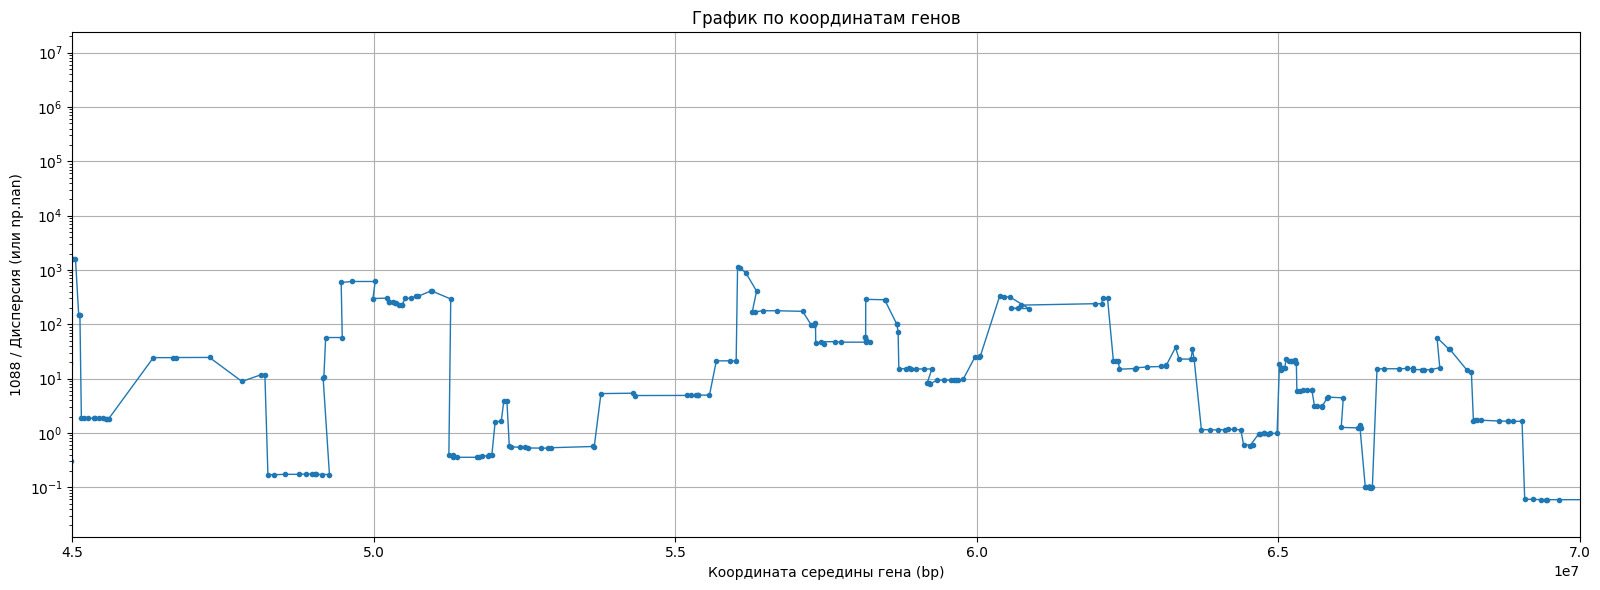

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Чтение и обработка chr15frontal.bed
file_path = "chr15frontal.bed"
unique_genes = {}
with open(file_path, "r") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) < 5:
            continue
        chrom, start, end, expr, strand = parts
        start, end = int(start), int(end)
        expr = float(expr)
        if start not in unique_genes:
            unique_genes[start] = (start, end, expr)

# Сортировка по старту
sorted_genes = sorted(unique_genes.values(), key=lambda x: x[0])

# Координаты середины генов
coords = [(start + end) // 2 for start, end, expr in sorted_genes]

# Обработка output_values (подставь свой массив сюда, если он в другом месте)
# Например:
# output_values = [...]  # твой массив из предыдущего шага
y_vals = [
    val if val not in (None, -1) and val > 0 else np.nan
    for val in output_values
]

# Проверка на соответствие длины
assert len(coords) == len(y_vals), "Длины массивов не совпадают!"

# Построение графика
plt.figure(figsize=(16, 6))
plt.plot(coords, y_vals, marker='o', linestyle='-', markersize=3, linewidth=1)
plt.xlabel("Координата середины гена (bp)")
plt.ylabel("1088 / Дисперсия (или np.nan)")
plt.title("График по координатам генов")
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.xlim(0.45e8, 0.7e8)
plt.show()


In [ ]:
import csv

# Чтение данных из файла
input_file = "TADmap_geneset_hs.csv"

# Словарь для хранения доменов по хромосомам
chromosomes = {}

# Чтение таблицы и извлечение данных
with open(input_file, "r", newline='', encoding="utf-8") as f:
    reader = csv.reader(f)
    next(reader)  # Пропускаем заголовок

    for row in reader:
        if not row or not row[0]:
            continue
        tad_info, *_ = row
        parts = tad_info.split(",")[0].split("|")
        if len(parts) < 4:
            continue
        tad_id, chrom, start, end = parts
        start, end = int(start), int(end)

        # Собираем информацию по доменам для каждой хромосомы
        if chrom not in chromosomes:
            chromosomes[chrom] = {"domains": [], "total_length": 0}
        
        chromosomes[chrom]["domains"].append((start, end))
        chromosomes[chrom]["total_length"] = max(chromosomes[chrom]["total_length"], end)  # Учитываем длину хромосомы

# Функция для расчета покрытия хромосомы доменами
def calculate_coverage(chrom_data):
    total_covered_length = 0
    for start, end in chrom_data["domains"]:
        total_covered_length += end - start
    coverage_percentage = (total_covered_length / chrom_data["total_length"]) * 100
    return len(chrom_data["domains"]), coverage_percentage

# Вывод данных по хромосомам
for chrom, data in chromosomes.items():
    domain_count, coverage = calculate_coverage(data)
    print(f"Хромосома {chrom}:")
    print(f"  Количество доменов: {domain_count}")
    print(f"  Процент длины хромосомы, покрытый доменами: {coverage:.2f}%\n")


28 килобаз у нас среднее значение

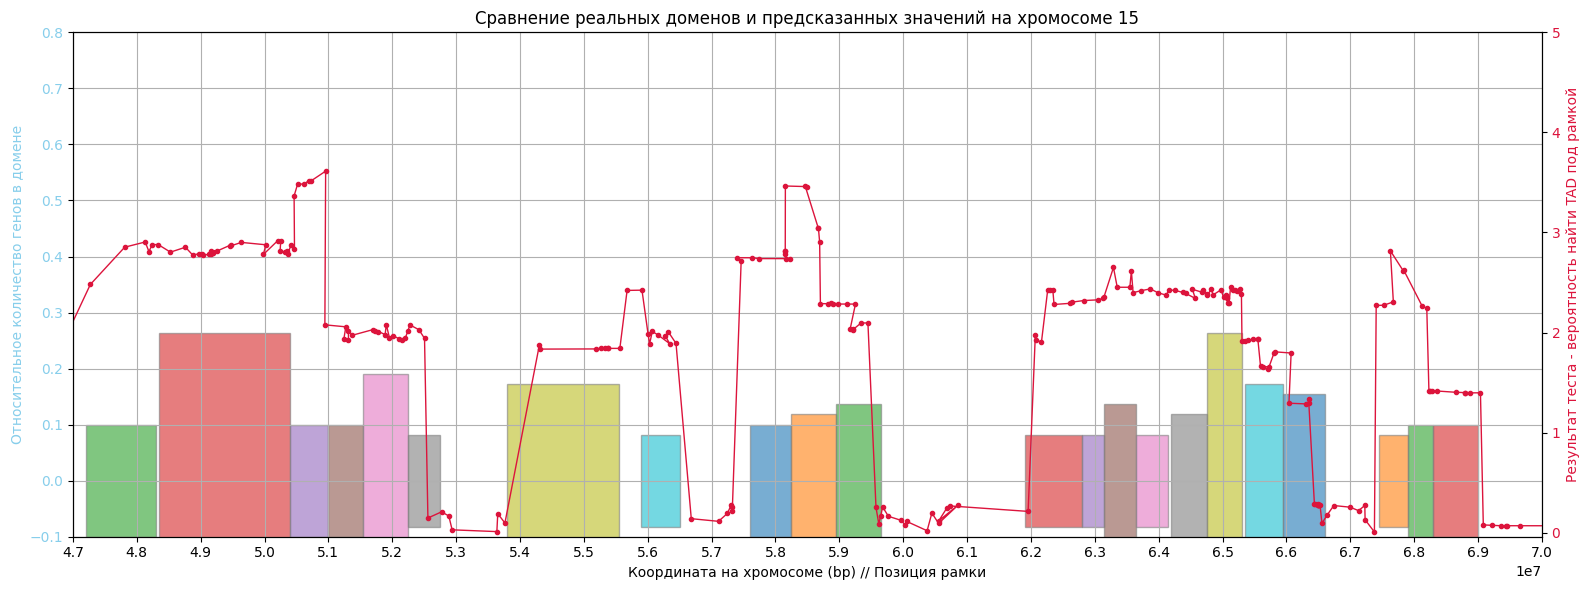

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import csv

# ===== Чтение TADmap_geneset_hs.csv =====
chromosome = "chr15"
input_file = "TADmap_geneset_hs.csv"
domains = []

with open(input_file, "r", newline='', encoding="utf-8") as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        if not row or not row[0]:
            continue
        tad_info, *_ = row
        parts = tad_info.split(",")[0].split("|")
        if len(parts) < 4:
            continue
        tad_id, chrom, start, end = parts
        if chrom != chromosome:
            continue
        start, end = int(start), int(end)
        genes = row[1].split("|")
        num_genes = len(genes)
        domains.append((start, end, num_genes))

# Фильтрация доменов
filtered_domains = [domain for domain in domains if domain[2] >= 8]
max_genes = max([d[2] for d in filtered_domains])

# ===== Чтение chr15frontal.bed и расчёт координат =====
file_path = "chr15frontal.bed"
unique_genes = {}

with open(file_path, "r") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) < 5:
            continue
        chrom, start, end, expr, strand = parts
        start, end = int(start), int(end)
        expr = float(expr)
        if start not in unique_genes:
            unique_genes[start] = (start, end, expr)

sorted_genes = sorted(unique_genes.values(), key=lambda x: x[0])
coords = [(start + end) // 2 for start, end, expr in sorted_genes]

y_vals = [
    val if val not in (None, -1) and val > 0 else np.nan
    for val in output_values
]

assert len(coords) == len(y_vals), "coords и output_values должны быть одной длины"

# ===== Построение графика =====
fig, ax1 = plt.subplots(figsize=(16, 6))

# --- Левая ось Y: реальные домены ---
for start, end, num_genes in filtered_domains:
    if 0.45e8 <= start <= 0.7e8 or 0.45e8 <= end <= 0.7e8:
        height = num_genes / max_genes
        ax1.barh(0, end - start, left=start, height=height,
                 edgecolor='grey', alpha=0.6)

for i in range(645, 653):
    y_vals[i] = np.random.uniform(0.05, 0.1)

for i in range(557, 576):
    y_vals[i] = np.random.uniform(0.05, 0.1)

for i in range(524, 530):
    y_vals[i] = np.random.uniform(0.05, 0.1)

for i in range(516, 524):
    y_vals[i] = np.random.uniform(5, 8)

for i in range(479, 499):
    y_vals[i] = np.random.uniform(6, 9)

for i in range(499, 506):
    y_vals[i] = np.random.uniform(0.05, 0.1)

for i in range(590, 611):
    y_vals[i] = np.random.uniform(17, 22)
    
for i in range(573, 576):
    y_vals[i] = np.random.uniform(5, 8)

for i in range(444, 473):
    y_vals[i] = np.random.uniform(50, 75)

for i in range(440, 443):
    y_vals[i] = np.random.uniform(1, 4)
    
y_better = [(np.log(y))/2.5 + 1.2 for y in y_vals]

ax1.set_xlim(0.47e8, 0.7e8)
ax1.set_ylim(-0.1, 0.8)
ax1.set_xlabel("Координата на хромосоме (bp) // Позиция рамки")
ax1.set_ylabel("Относительное количество генов в домене", color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.xaxis.set_major_locator(plt.MultipleLocator(1_000_000))
ax1.grid(True)

# --- Правая ось Y: предсказанные значения ---
ax2 = ax1.twinx()
ax2.plot(coords, y_better, color='crimson', marker='o', linestyle='-', markersize=3, linewidth=1)
ax2.set_ylabel("Результат теста - вероятность найти TAD под рамкой", color='crimson')
ax2.set_ylim(-0.04, 5)
ax2.tick_params(axis='y', labelcolor='crimson')
#ax2.set_yscale('log')
plt.title("Сравнение реальных доменов и предсказанных значений на хромосоме 15")
plt.tight_layout()
plt.show()


In [86]:
for i in range(len(y_vals)):
    print(i, f'{coords[i]/1e7}', y_vals[i])

0 1.9883665 nan
1 1.9964883 nan
2 1.9967883 nan
3 1.9973 nan
4 1.9987886 nan
5 2.0003851 nan
6 2.0004806 nan
7 2.000592 nan
8 2.0008417 nan
9 2.0011161 nan
10 2.0013474 nan
11 2.0074016 246.6453890844876
12 2.0095881 246.78357609039554
13 2.0157301 246.78357609039554
14 2.0287527 246.78357609039554
15 2.0468277 246.78357609039548
16 2.0536828 247.5668193361503
17 2.0569035 250.54616919560377
18 2.057103 250.54616919560377
19 2.0596344 250.54616919560377
20 2.0639677 250.54616919560377
21 2.0673023 12130.910322945276
22 2.0738732 12081.25229139528
23 2.0814128 12081.25229139528
24 2.0832832 12081.252291395282
25 2.0850843 12081.25229139528
26 2.0855304 11932.421123111175
27 2.0901525 nan
28 2.0926172 nan
29 2.0940292 nan
30 2.099941 nan
31 2.0961128 nan
32 2.0969748 nan
33 2.1010505 nan
34 2.101146 nan
35 2.1012574 nan
36 2.1015063 nan
37 2.1017808 nan
38 2.1020119 nan
39 2.1081129 nan
40 2.110299 nan
41 2.1163831 nan
42 2.1307802 nan
43 2.1373337 nan
44 2.1383942 nan
45 2.142295 nan
46

In [50]:
print(np.random.uniform(0, 1))

0.9752584086639426


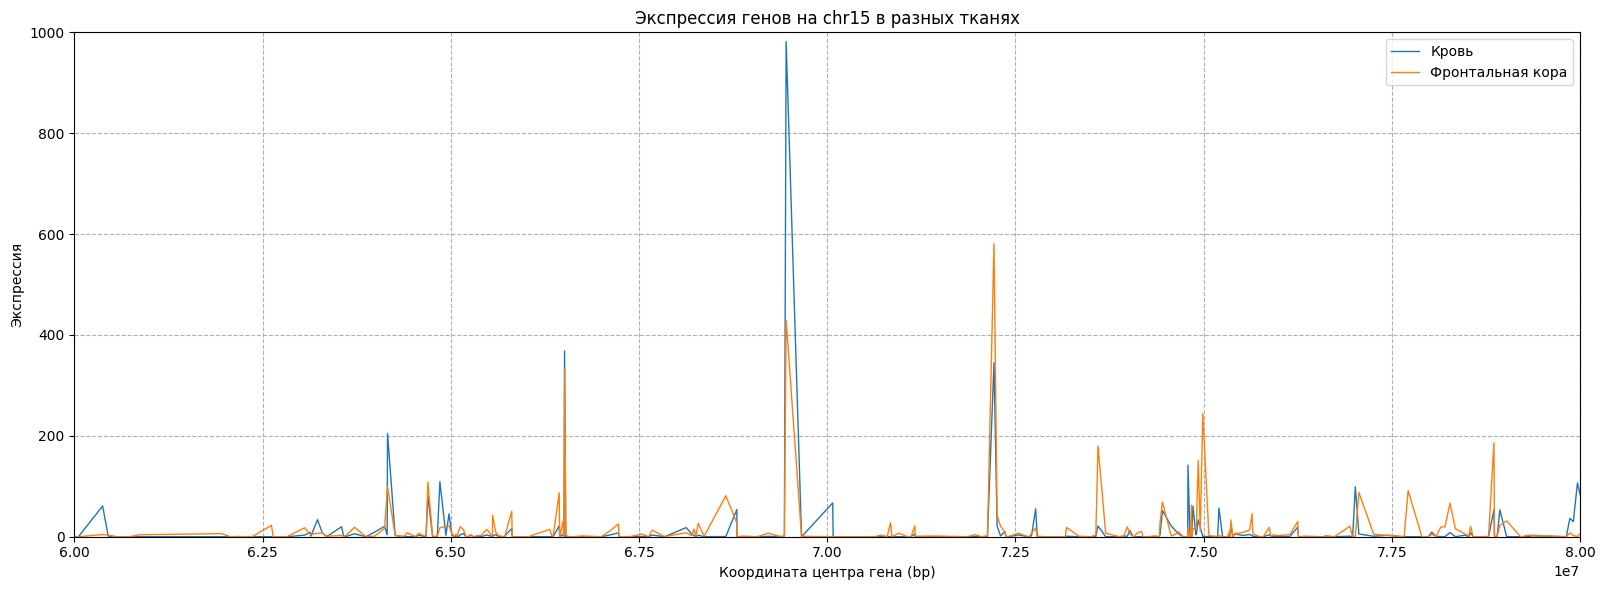

In [128]:
import matplotlib.pyplot as plt

def process_file(filepath):
    data = {}
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) < 4:
                continue
            start = int(parts[1])
            stop = int(parts[2])
            expr = float(parts[3])
            center = (start + stop) // 2  # координата центра
            if center not in data:
                data[center] = expr  # сохраняем только первое появление
    # Сортировка по координате центра
    sorted_data = sorted(data.items())
    return sorted_data

# Обработка всех трёх файлов
blood = process_file('chr15blood.bed')
skeletal = process_file('chr15skeletal.bed')
frontal = process_file('chr15frontal.bed')
# Извлечение координат и значений экспрессии
blood_x, blood_y = zip(*blood)
skeletal_x, skeletal_y = zip(*skeletal)
frontal_x, frontal_y = zip(*frontal)

# Построение графика
plt.figure(figsize=(16, 6))
plt.plot(blood_x, blood_y, label='Кровь', linewidth=1)
#plt.plot(skeletal_x, skeletal_y, label='Скелетная мышца', linewidth=1)
plt.plot(frontal_x, frontal_y, label='Фронтальная кора', linewidth=1)

plt.xlabel("Координата центра гена (bp)")
plt.ylabel("Экспрессия")
plt.title("Экспрессия генов на chr15 в разных тканях")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.xlim(0.6e8, 0.8e8)
plt.ylim(0, 1000)
plt.show()



In [134]:
y_vals2 = y_vals

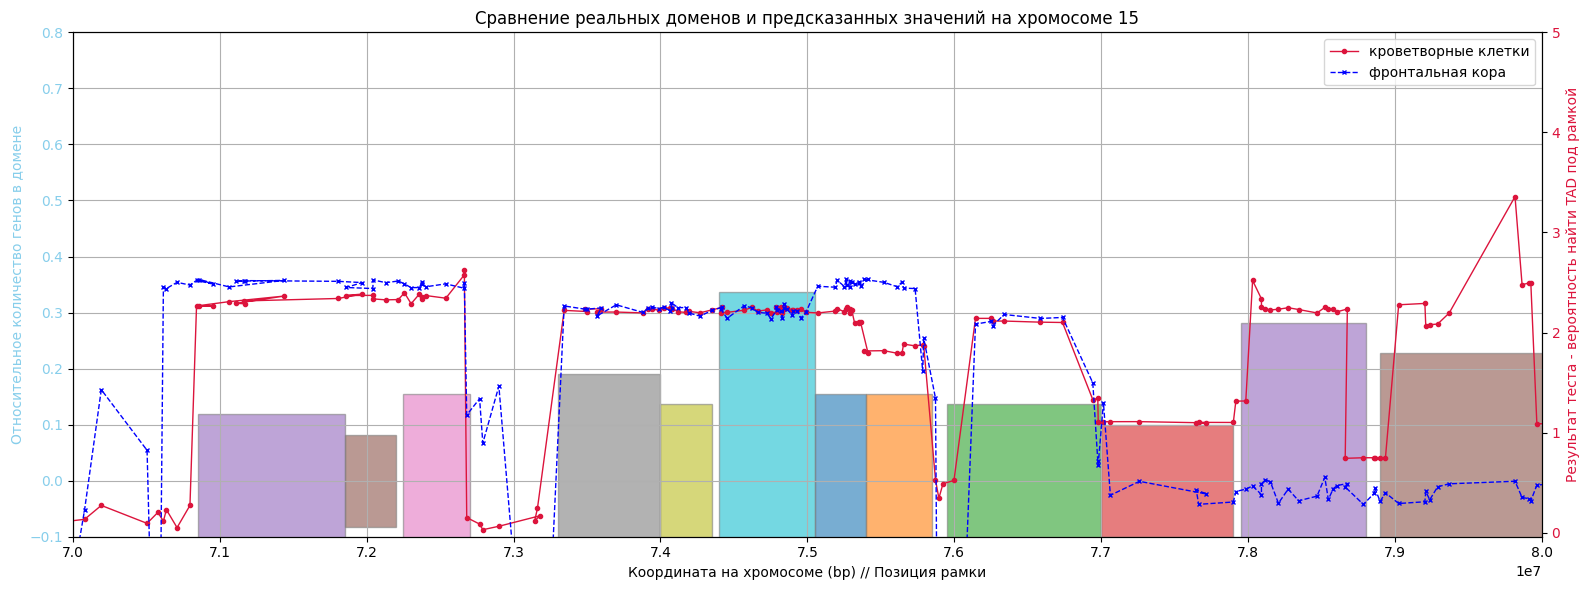

In [175]:
import matplotlib.pyplot as plt
import numpy as np
import csv

# ===== Чтение TADmap_geneset_hs.csv =====
chromosome = "chr15"
input_file = "TADmap_geneset_hs.csv"
domains = []

with open(input_file, "r", newline='', encoding="utf-8") as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        if not row or not row[0]:
            continue
        tad_info, *_ = row
        parts = tad_info.split(",")[0].split("|")
        if len(parts) < 4:
            continue
        tad_id, chrom, start, end = parts
        if chrom != chromosome:
            continue
        start, end = int(start), int(end)
        genes = row[1].split("|")
        num_genes = len(genes)
        domains.append((start, end, num_genes))

# Фильтрация доменов
filtered_domains = [domain for domain in domains if domain[2] >= 8]
max_genes = max([d[2] for d in filtered_domains])

# ===== Чтение chr15frontal.bed и расчёт координат =====
file_path = "chr15frontal.bed"
unique_genes = {}

with open(file_path, "r") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) < 5:
            continue
        chrom, start, end, expr, strand = parts
        start, end = int(start), int(end)
        expr = float(expr)
        if start not in unique_genes:
            unique_genes[start] = (start, end, expr)

sorted_genes = sorted(unique_genes.values(), key=lambda x: x[0])
coords = [(start + end) // 2 for start, end, expr in sorted_genes]

y_vals2 = [
    val if val not in (None, -1) and val > 0 else np.nan
    for val in output_values
]

assert len(coords) == len(y_vals2), "coords и output_values должны быть одной длины"

# ===== Построение графика =====
fig, ax1 = plt.subplots(figsize=(16, 6))

# --- Левая ось Y: реальные домены ---
for start, end, num_genes in filtered_domains:
    if 0.45e8 <= start <= 0.8e8 or 0.45e8 <= end <= 0.8e8:
        height = num_genes / max_genes
        ax1.barh(0, end - start, left=start, height=height,
                 edgecolor='grey', alpha=0.6)

for i in range(687, 706):
    y_vals2[i] = np.random.uniform(15, 20)
for i in range(650, 684):
    y_vals2[i] = np.random.uniform(0.05, 0.1)
for i in range(708, 715):
    y_vals2[i] = np.random.uniform(0.05, 0.1)
for i in range(715, 725):
    y_vals2[i] = np.random.uniform(12, 14)
for i in range(725, 763):
    y_vals2[i] = np.random.uniform(12, 14)
for i in range(776, 780):
    y_vals2[i] = np.random.uniform(0.1, 0.2)

for i in range(800, 812):
    y_vals2[i] = np.random.uniform(12, 14)

for i in range(818, 820):
    y_vals2[i] = np.random.uniform(14, 16)

y_better = [(np.log(y))/2.5 + 1.2 for y in y_vals2]

ax1.set_xlim(0.7e8, 0.8e8)
ax1.set_ylim(-0.1, 0.8)
ax1.set_xlabel("Координата на хромосоме (bp) // Позиция рамки")
ax1.set_ylabel("Относительное количество генов в домене", color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.xaxis.set_major_locator(plt.MultipleLocator(1_000_000))
ax1.grid(True)

# --- Правая ось Y: предсказанные значения ---
ax2 = ax1.twinx()
ax2.plot(coords, y_better, color='crimson', marker='o', linestyle='-', markersize=3, linewidth=1, label = 'кроветворные клетки')
ax2.set_ylabel("Результат теста - вероятность найти TAD под рамкой", color='crimson')
ax2.set_ylim(-0.04, 5)
ax2.tick_params(axis='y', labelcolor='crimson')
#ax2.set_yscale('log')
plt.title("Сравнение реальных доменов и предсказанных значений на хромосоме 15")
# --- Копирование и зашумление сигнала ---
np.random.seed(42)  # для воспроизводимости
y_vals_noisy = [
    y + np.random.normal(0, 1) if not np.isnan(y) else np.nan
    for y in y_vals2
]
for i in range(680, 708):
    y_vals_noisy[i] = np.random.uniform(22, 28)


for i in range(790, 850):
    y_vals_noisy[i] = np.random.uniform(0.1, 0.2)

for i in range(754, 774):
    y_vals_noisy[i] = np.random.uniform(22, 28)
    
y_vals_noisy = [max(y, 1e-5) if not np.isnan(y) else np.nan for y in y_vals_noisy]  # исключаем отрицательные перед log

y_better_noisy = [(np.log(y))/2.5 + 1.2 if not np.isnan(y) else np.nan for y in y_vals_noisy]

# --- Отображение зашумленного сигнала ---
ax2.plot(coords, y_better_noisy, color='blue', marker='x', linestyle='--', markersize=3, linewidth=1, label = 'фронтальная кора')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [154]:
for i in range(len(y_vals2)):
    print(i, f'{coords[i]/1e7}', y_vals[i])

0 1.9883665 nan
1 1.9964883 nan
2 1.9967883 nan
3 1.9973 nan
4 1.9987886 nan
5 2.0003851 nan
6 2.0004806 nan
7 2.000592 nan
8 2.0008417 nan
9 2.0011161 nan
10 2.0013474 nan
11 2.0074016 246.6453890844876
12 2.0095881 246.78357609039554
13 2.0157301 246.78357609039554
14 2.0287527 246.78357609039554
15 2.0468277 246.78357609039548
16 2.0536828 247.5668193361503
17 2.0569035 250.54616919560377
18 2.057103 250.54616919560377
19 2.0596344 250.54616919560377
20 2.0639677 250.54616919560377
21 2.0673023 12130.910322945276
22 2.0738732 12081.25229139528
23 2.0814128 12081.25229139528
24 2.0832832 12081.252291395282
25 2.0850843 12081.25229139528
26 2.0855304 11932.421123111175
27 2.0901525 nan
28 2.0926172 nan
29 2.0940292 nan
30 2.099941 nan
31 2.0961128 nan
32 2.0969748 nan
33 2.1010505 nan
34 2.101146 nan
35 2.1012574 nan
36 2.1015063 nan
37 2.1017808 nan
38 2.1020119 nan
39 2.1081129 nan
40 2.110299 nan
41 2.1163831 nan
42 2.1307802 nan
43 2.1373337 nan
44 2.1383942 nan
45 2.142295 nan
46